In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scienceplots

from nanonets import Simulation
from nanonets.utils import load_simulation_results

plt.style.use(["science","bright","grid"])

# PARAMETERS
V_INPUT_MAX = 0.1
N_INPUTS    = 320
N_PARTICLES = [3,4,5,6,7,8,9,10,11,12,13,14,15]
N_E         = 2
V_INPUT     = np.round(np.linspace(-V_INPUT_MAX, V_INPUT_MAX, N_INPUTS),4)
V_I_PLOT    = 1000*V_INPUT
PATH        = "/home/jonasmensing/bagheera/data/1_funding_period/iv_curves/networks/"
AC_TIME     = 40e-9
BATCH_TIME  = 20*AC_TIME
ELE_CHARGE  = 0.160217662
I_MIN       = ELE_CHARGE / (20*BATCH_TIME)

### Theory

In [72]:
y_theory = {}
for n in N_PARTICLES:
    if N_E == 2:
        topo = {"Nx": n, "Ny": n,
                "e_pos" : [[int((n-1)/2),0],[int((n)/2),(n-1)]],
                "electrode_type" : ['constant']*N_E}
    else:
        topo = {"Nx": n, "Ny": n,
                "e_pos" : [[int((n-1)/2),0],[0,0],[n-1,0],[0,int((n-1)/2)],
                [n-1,int((n)/2)],[0,n-1],[n-1,n-1],[int((n)/2),(n-1)]],
                "electrode_type" : ['constant']*N_E}
    sim_c = Simulation(topo)
    sim_c.build_conductance_matrix()
    sim_c.init_transfer_coeffs()
    G_eff = sim_c.get_transfer_coeffs()[0]
    I_ohm = G_eff * V_INPUT
    y_theory[n] = I_ohm

### IV Curve

In [73]:
data = load_simulation_results(PATH,N_PARTICLES,N_E)

y   = {N : data[N]['Observable'].values for N in N_PARTICLES}
y_e = {N : data[N]['Error'].values for N in N_PARTICLES}
l_t = {N : np.abs(y[N]) < I_MIN for N in N_PARTICLES}

# Set Currents via mask to Zero
for N in N_PARTICLES:
    y[N][l_t[N]] = 0.0
    y_e[N][l_t[N]] = 0.0

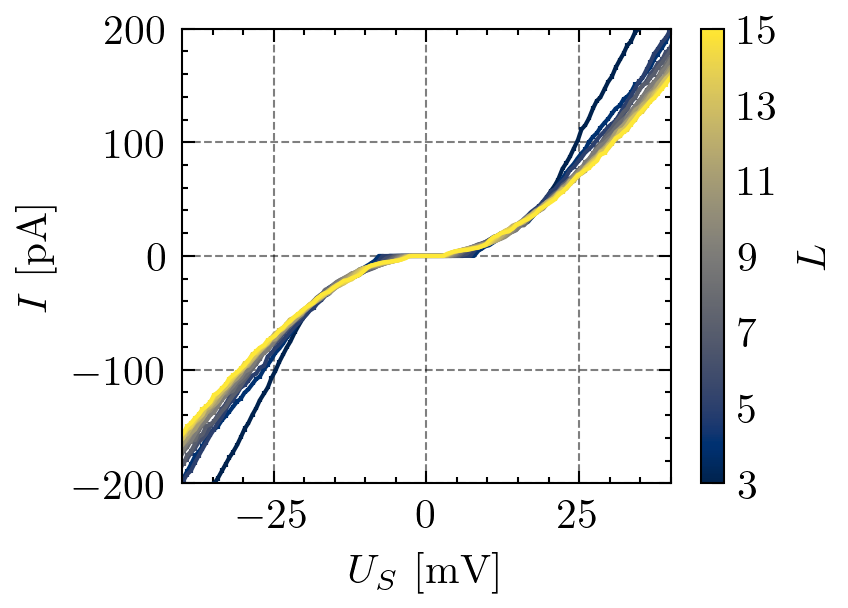

In [74]:
cmap    = plt.get_cmap('cividis')
norm    = mcolors.Normalize(vmin=min(N_PARTICLES),vmax=max(N_PARTICLES))
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _ = ax.errorbar(V_INPUT[:len(y[N])]*1000, y[N]*1e-6, y_e[N]*1e-6, color=cmap(norm(N)))
_   = ax.set_xlabel("$U_S~[\mathrm{mV}]$")
_   = ax.set_ylabel("$I~[\mathrm{pA}]$")
if N_E == 8:
    _   = ax.set_xlim(-25,25)
    _   = ax.set_ylim(-10,10)
if N_E == 2:
    _   = ax.set_xlim(-40,40)
    _   = ax.set_ylim(-200,200)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$L$")
cbar.set_ticks(N_PARTICLES[::2])

fig.savefig(f"plots/svg/network_iv_curves_Ne={N_E}.svg", transparent=True)
fig.savefig(f"plots/pdf/network_iv_curves_Ne={N_E}.pdf", transparent=False)
fig.savefig(f"plots/png/network_iv_curves_Ne={N_E}.png", transparent=False)

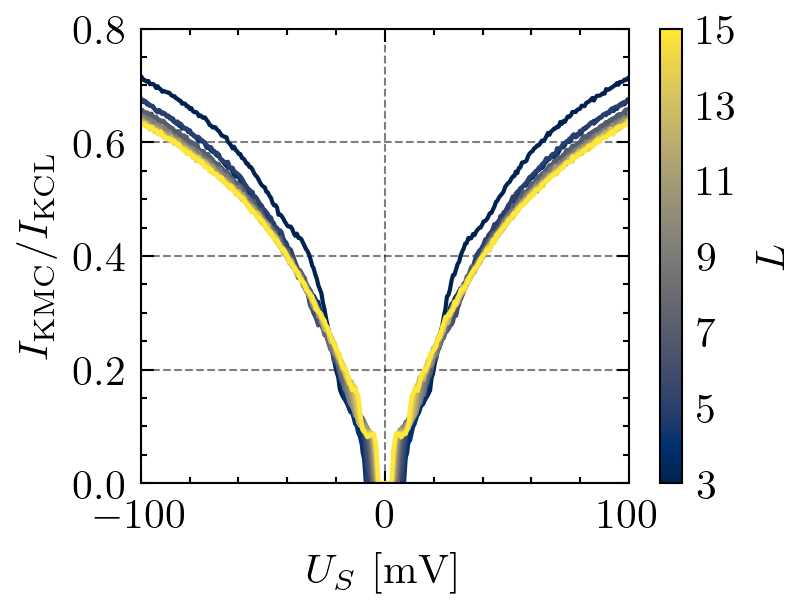

In [77]:
cmap    = plt.get_cmap('cividis')
norm    = mcolors.Normalize(vmin=min(N_PARTICLES),vmax=max(N_PARTICLES))
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _ = ax.plot(V_INPUT*1000, (y[N]*1e-6)/(y_theory[N]*1e12), color=cmap(norm(N)))
_   = ax.set_xlabel("$U_S~[\mathrm{mV}]$")
_   = ax.set_ylabel("$I_\\textrm{KMC}/I_\\textrm{KCL}$")
_   = ax.set_xlim(-100,100)
_   = ax.set_ylim(0,0.8)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$L$")
cbar.set_ticks(N_PARTICLES[::2])

fig.savefig(f"plots/svg/network_iv_KCL_vs_KMC_Ne={N_E}.svg", transparent=True)
fig.savefig(f"plots/pdf/network_iv_KCL_vs_KMC_Ne={N_E}.pdf", transparent=False)
fig.savefig(f"plots/png/network_iv_KCL_vs_KMC_Ne={N_E}.png", transparent=False)

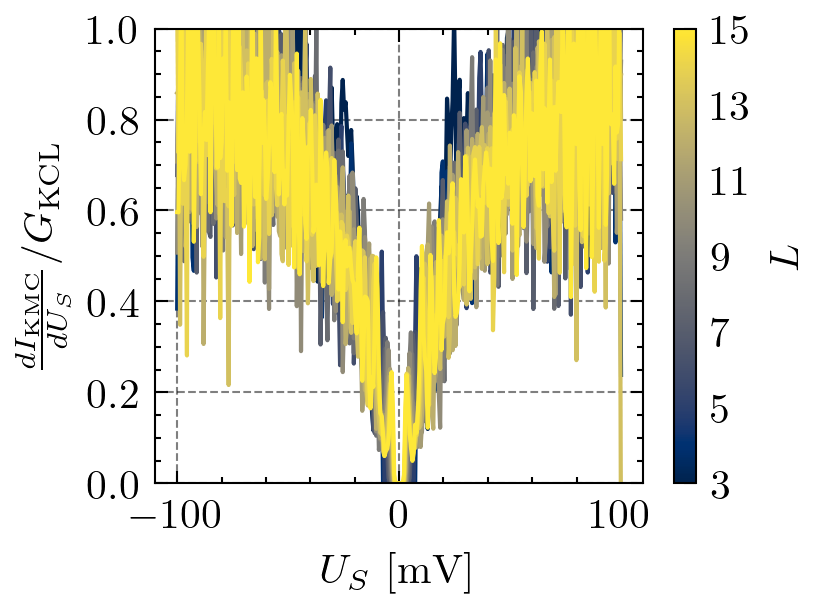

In [82]:
cmap    = plt.get_cmap('cividis')
norm    = mcolors.Normalize(vmin=min(N_PARTICLES),vmax=max(N_PARTICLES))
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    dI      = np.gradient(y[N]*1e-6, V_INPUT)
    G_kcl   = (y_theory[N][-1]*1e12 - y_theory[N][0]*1e12) / (V_INPUT[-1] - V_INPUT[0])
    normalized_conductance = dI / G_kcl
    
    ax.plot(V_INPUT*1000, normalized_conductance, color=cmap(norm(N)))
_   = ax.set_xlabel("$U_S~[\mathrm{mV}]$")
_   = ax.set_ylabel("$\\frac{dI_\\textrm{KMC}}{dU_S}/G_\\textrm{KCL}$")
# _   = ax.set_xlim(-100,100)
_   = ax.set_ylim(0,1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$L$")
cbar.set_ticks(N_PARTICLES[::2])

# fig.savefig(f"plots/svg/network_iv_KCL_vs_KMC_Ne={N_E}.svg", transparent=True)
# fig.savefig(f"plots/pdf/network_iv_KCL_vs_KMC_Ne={N_E}.pdf", transparent=False)
# fig.savefig(f"plots/png/network_iv_KCL_vs_KMC_Ne={N_E}.png", transparent=False)